# Apply spaTrack on spatial data of Intrahepatic cholangiocarcinoma cancer

Rebuilding lineages of tumorigenesis can improve us understand the deterioration and developmental process of primary tumors and describe the behaviors of malignant cells.Considering the heterozygosity and complex of malignant cells, it is possible that tumors originate from multiple starte regions. Here, we performed spaTrack to rebuild the diverse lineages of ICC tumorigenesis by spatial transcriptomics data of ICC tumor section. This notebook uses the intrahepatic cholangiocarcinoma cancer (ICC) ST data to show how spaTrack infer trajectories when data has multiple origins. Spatial transcriptomics data of ICC can be download from [Baidu Netdisk](https://pan.baidu.com/s/1I1HS6w4BDuDCeZfrjRE9WA?pwd=6ve6) and [Google Drive](https://drive.google.com/file/d/1LI0M5xhX6v-j9d7R8x2eDJzY159sNDUS/view?usp=sharing).

In [1]:
import spaTrack as spt
import single_time as spt

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 200 #分辨率

/home/huangke2/huangke2_694/software/conda/envs/ST/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning:

The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.

/home/huangke2/huangke2_694/software/conda/envs/ST/lib/python3.8/site-packages/spaghetti/network.py:40: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.



## 1. Prepare ICC adata

Convert tsv files to scanpy adata (the tsv file format was described in 01 notebook).

In [2]:
adata = sc.read("../data/primary.ICC.tumor.ST/ICC.primary.ST.exp_count.tsv", cache=True)
anno = pd.read_table("../data/primary.ICC.tumor.ST/ICC.primary.ST.annot.tsv")

# adata=sc.read('/home/huangke2/huangke2_694/27.spatial.trajectory/12.SpaTrack/14.test.data/ICC.new/ICC.primary.ST.exp_count.tsv')
# df_annot = pd.read_table("/home/huangke2/huangke2_694/27.spatial.trajectory/12.SpaTrack/14.test.data/ICC.new/ICC.primary.ST.annot.tsv")

adata.obs.index = df_annot["ID"].values
adata.obs["cluster"] = df_annot["cluster"].values
adata.obsm["X_spatial"] = df_annot[["x", "y"]].values
adata.layers["counts"] = adata.X

Perform basic preprocessing and visualize spatial data.

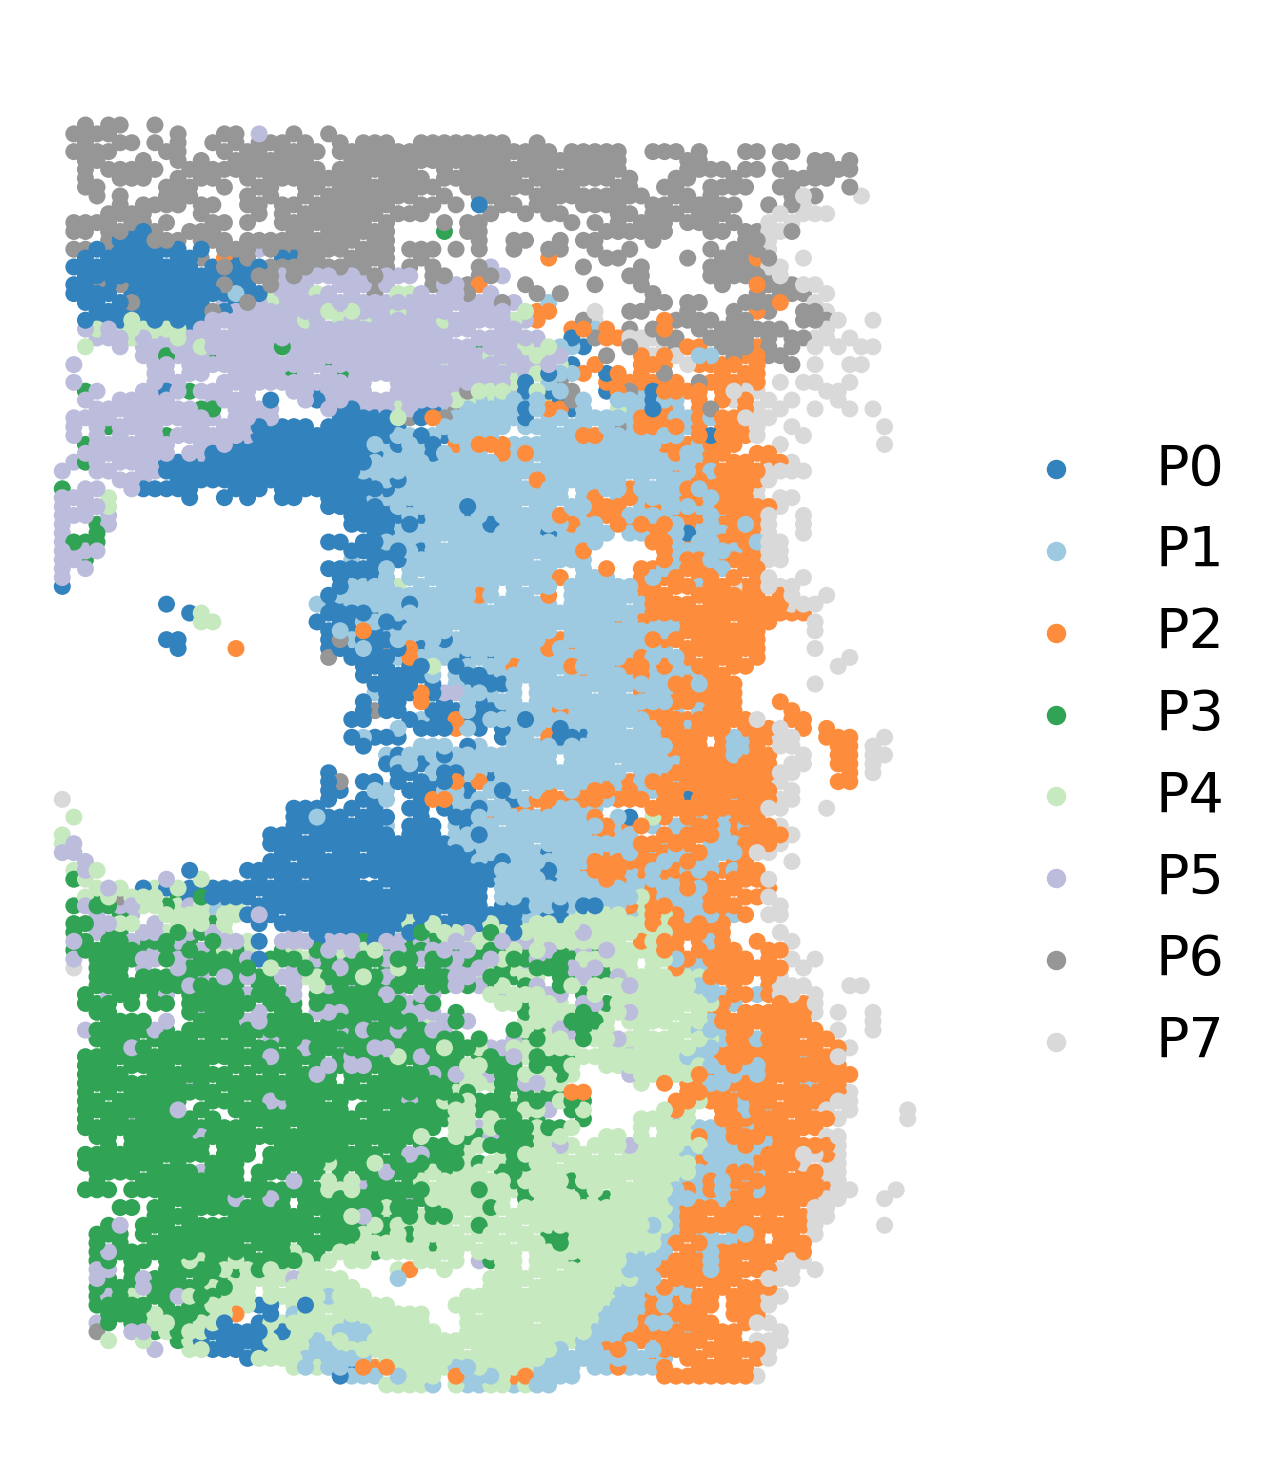

In [3]:
#adata.X=adata.layers["counts"]
sc.pp.filter_genes(adata,min_cells=10)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
fig, axs = plt.subplots(figsize=(6, 9))
ax = sc.pl.embedding(adata,  basis='X_spatial',show=False,color='cluster',ax=axs,frameon=False,title=' ',palette='tab20c',size=150, legend_fontsize=20)

## 2. Choose start cells

In order to identify potential start regions, multiple factors were considered. We recommend that users manually slecte starting cluster base on prior knowledge within this field. In cases where prior knowledge and biological evidence were not available to support the selection of start cells, we suggested using G2M score and stem cell differentitation score. 

In our analysis of the ICC tumor ST data, we found that the P0 cluster demonstrated a relatively high G2M score and stem cell differentiation score, indicating higher levels of cell proliferation compared to the other clusters. As a result, P0 was selected as the starting region for further investigation.

In [5]:
adata=spt.assess_start_cluster(adata)

Cluster order sorted by G2M score:  ['P0', 'P1', 'P2', 'P6', 'P4', 'P7', 'P3', 'P5']


G2M_score
P0   0.020130
P1   0.006271
P2  -0.006115
P6  -0.025164
P4  -0.025189
P7  -0.033233
P3  -0.051598
P5  -0.054865

Cluster order sorted by Stem Cell Differentiation score:  ['P0', 'P5', 'P6', 'P3', 'P2', 'P1', 'P4', 'P7']


Mean of Stem Cell Differentiation score  cell_number
P0                                 0.195828          759
P5                                 0.194364          670
P6                                 0.181888          629
P3                                 0.178778         1035
P2                                 0.176754          953
P1                                 0.176085         1246
P4                                 0.158732          915
P7                                 0.157976          228

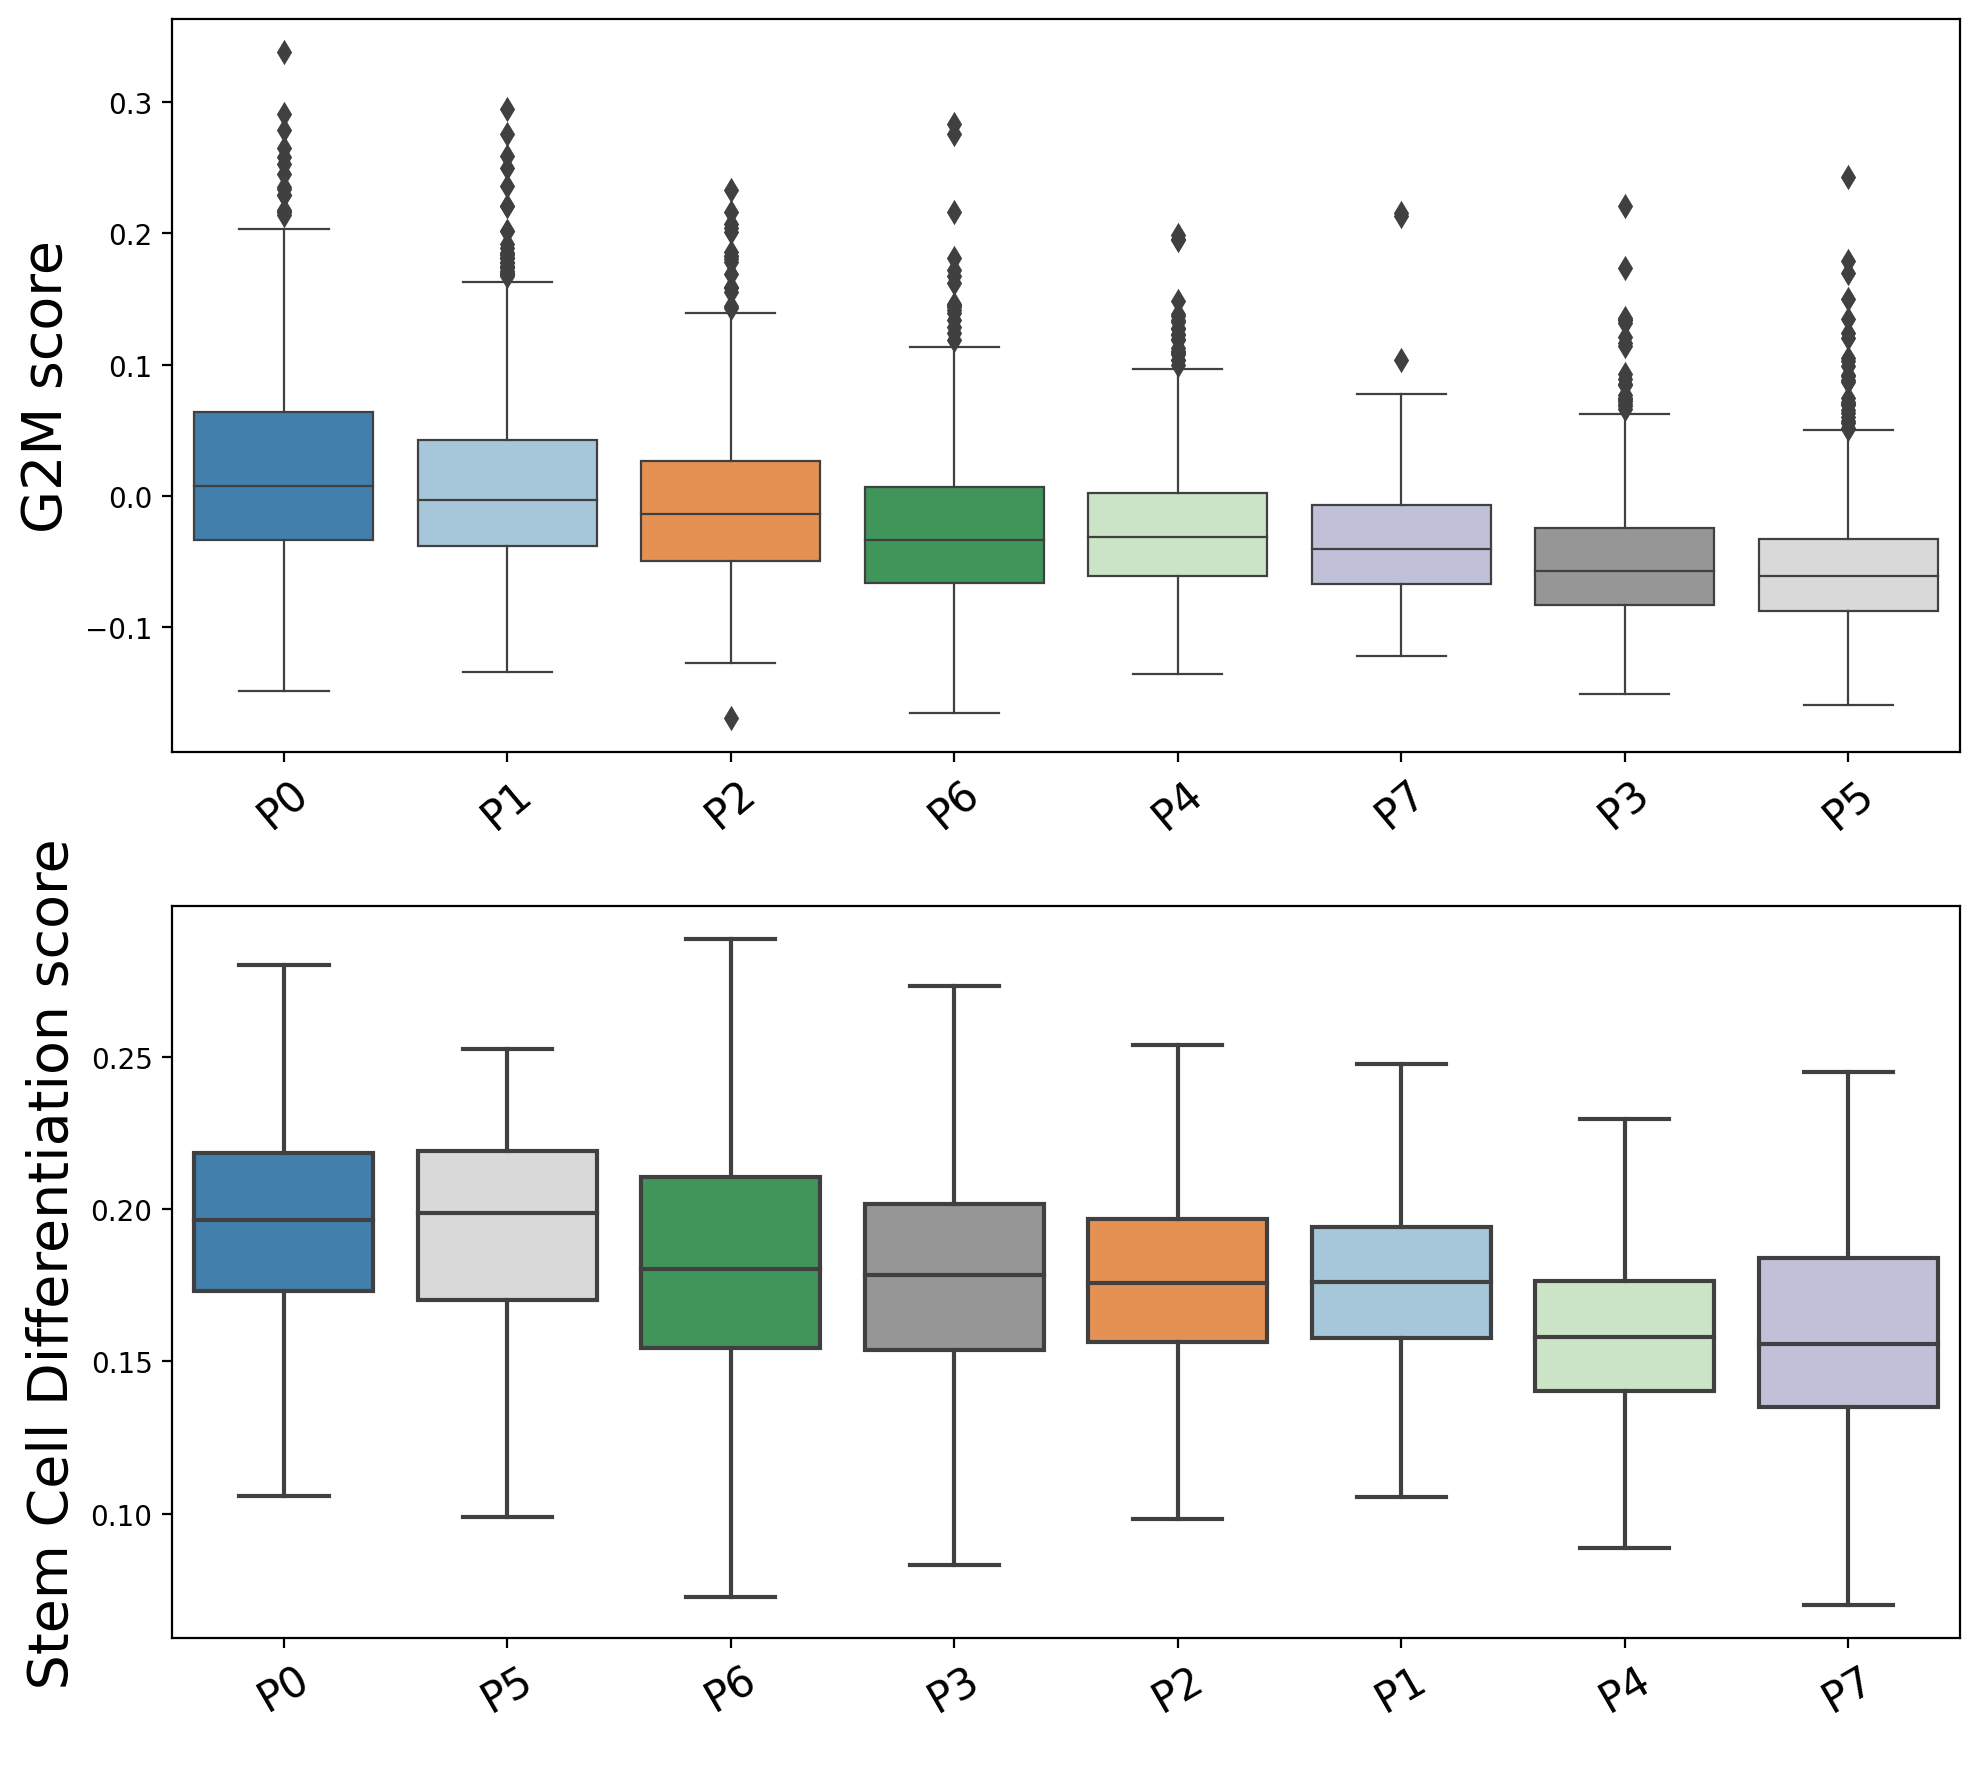

In [6]:
spt.assess_start_cluster_plot(adata)



Since the P0 cluster was distributed across four distinct regions, we used the k-means method with a cluster number of 4 to identify the aggregation points of the P0 cluster. Neighbor cells were then taken as start cells for the trajectory inference.

kmeans cluster centers:
[  866.37931034 16618.10344828]
[ 2811.91135734 10332.4099723 ]
[1654.16666667 4750.        ]
[ 2404.26356589 14189.92248062]


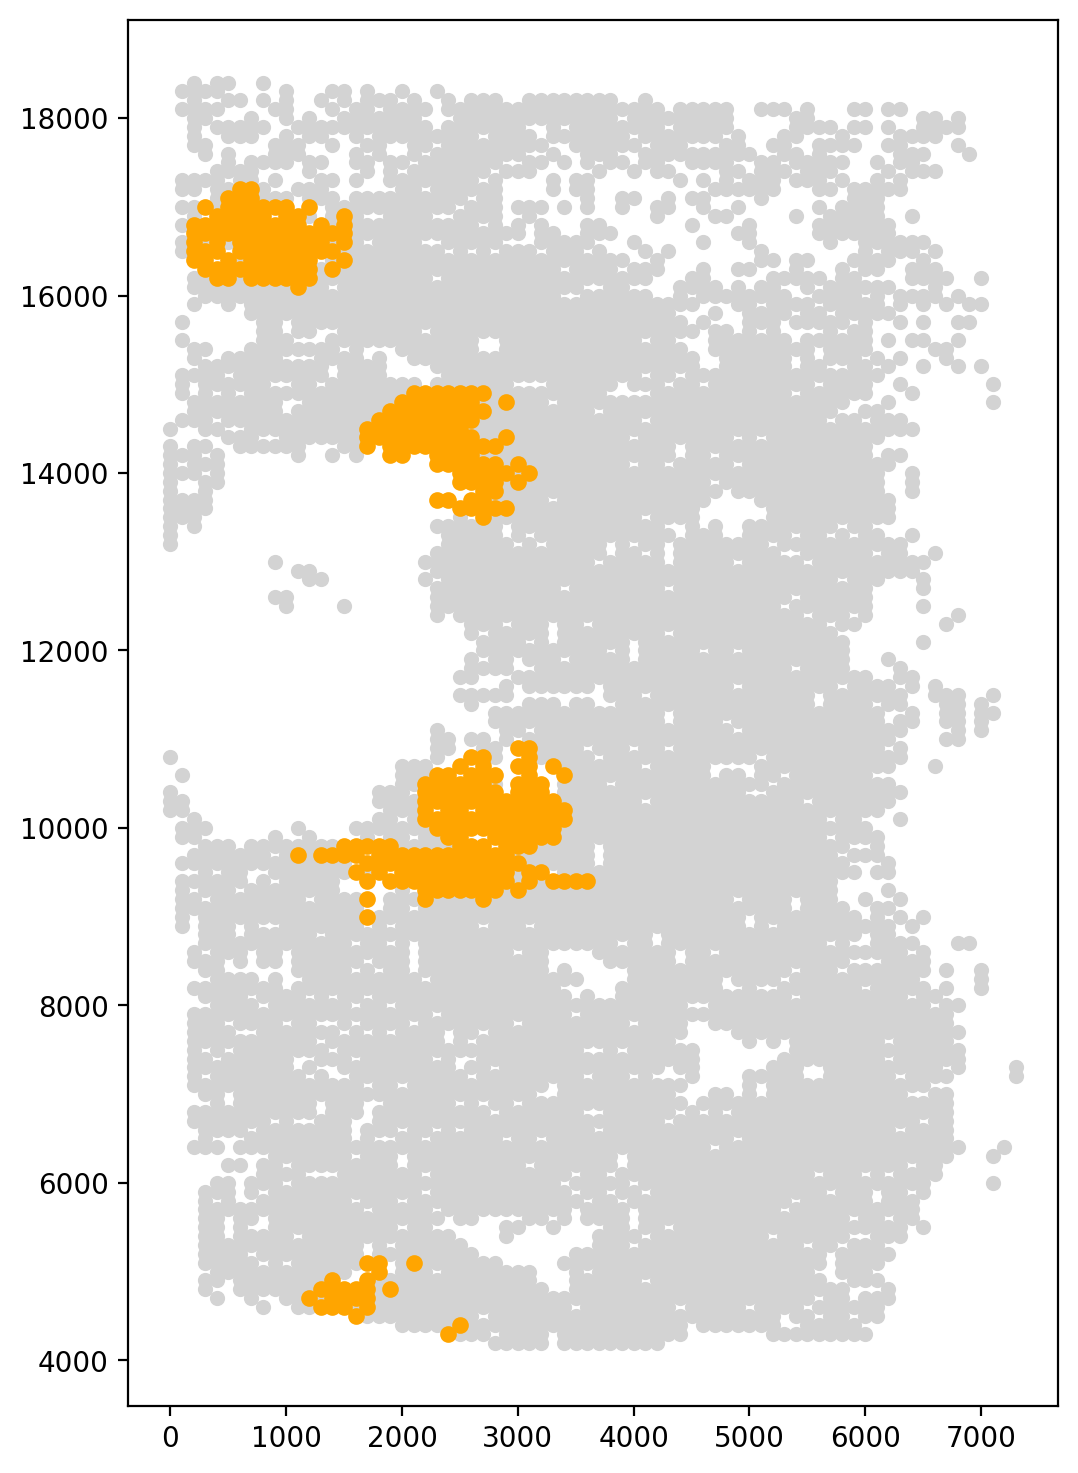

In [6]:
fig, axs = plt.subplots(figsize=(6, 9))
start_cells=spt.set_start_cells(adata,select_way='cell_type',split=True,cell_type='P0',n_neigh=100,n_clusters=4)

plt.scatter(adata.obsm['X_spatial'][:,0],adata.obsm['X_spatial'][:,1],c='#D3D3D3',s=20)
plt.scatter(adata.obsm['X_spatial'][start_cells][:,0],adata.obsm['X_spatial'][start_cells][:,1],c='orange',s=25)

## 3. Calculate cell transition probability

Parameter estimation of alpah1 for gene expression and alpah2 for spatial distance

In [9]:
alpha1, alpha2=spt.auto_estimate_para(adata,hvg_gene_number=2000)

Parameter estimation of alpah1 for spatial distance is: 0.5
Parameter estimation of alpah2 for gene expression is: 0.782


Calculate cell transition probability based on gene expression matrix and cell spatial coordinate.

In [10]:
#adata.obsp['trans']=spt.get_ot_matrix(adata,data_type='spatial',alpha1=0.5,alpha2=0.5)
adata.obsp['trans']=spt.get_ot_matrix(adata,data_type='spatial',alpha1=0.5,alpha2=0.784)

alpha1(spatial information): 0.5   alpha2(gene expression): 0.784


## 4. Caculate cell pseudotime

Assign a pseudo-time value to each cell.

In [11]:
adata.obs['ptime']=spt.get_ptime(adata,start_cells)

## 5. Calculate vector field velocity.

Calculate vector field velocity by averaging the velocities of each cell and its neighbors.

In [12]:
adata.uns['E_grid'],adata.uns['V_grid']=spt.get_velocity(adata,basis='spatial',n_neigh_pos=100)

The velocity of cells store in 'velocity_spatial'.


## 6. Plot results

Visualization of cell pseudotime and inferred cell trajectory.

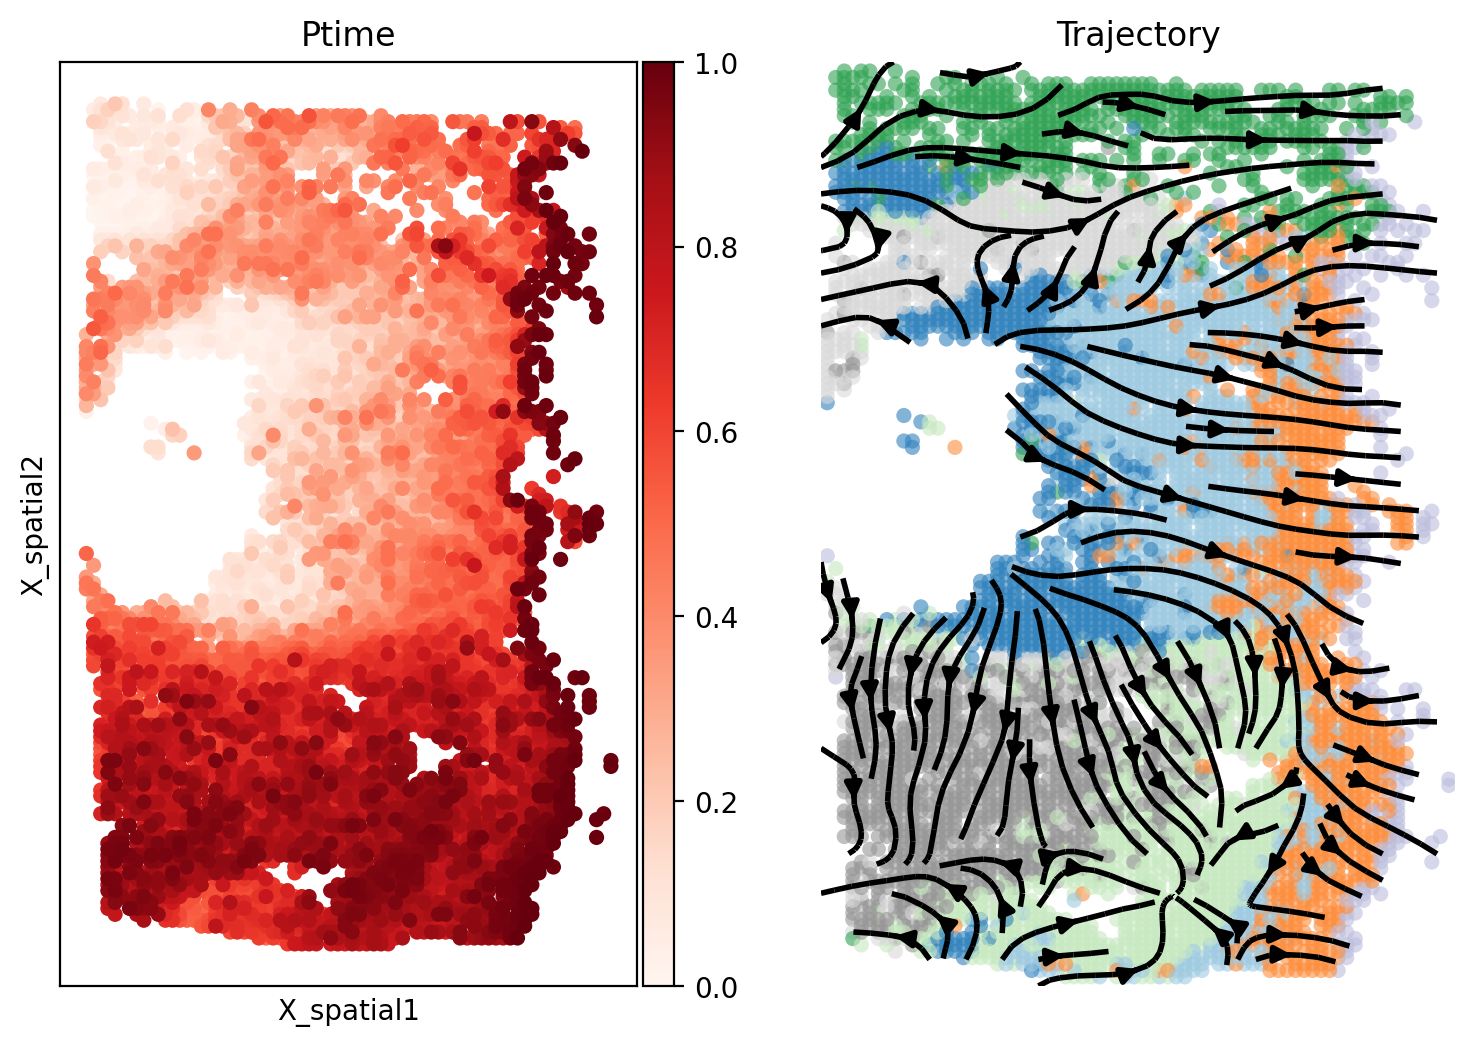

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 6))

sc.pl.embedding(adata, basis='X_spatial', color='ptime', show=False, ax=axs[0], color_map='Reds', title='Ptime',size=120)
vf_velocity = sc.pl.embedding(adata, basis='X_spatial', show=False, ax=axs[1],color='cluster', legend_loc=None, frameon=False, title='Trajectory', alpha=0.6, size=120)
vf_velocity.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1], color='black', linewidth=2,density=1.2,arrowsize=1.2)

## 7. Downstream analysis

In order to apply the LAP algorithm to spatial transcriptomics data, we need to reconstruct the grid-level vector field into cell-level data. This is done by interpolating the vector field values from the grid points to the cell locations, which enables us to calculate the velocity vectors for individual cells. The cell-level vector field is then used as input to the LAP algorithm to infer the optimal transition path between the chosen start and end points.

In [14]:
VecFld=spt.VectorField(adata,basis='spatial')

### 7.1 Least Action Path (LAP)

Select the start point and the end point across the direction of trajectory.

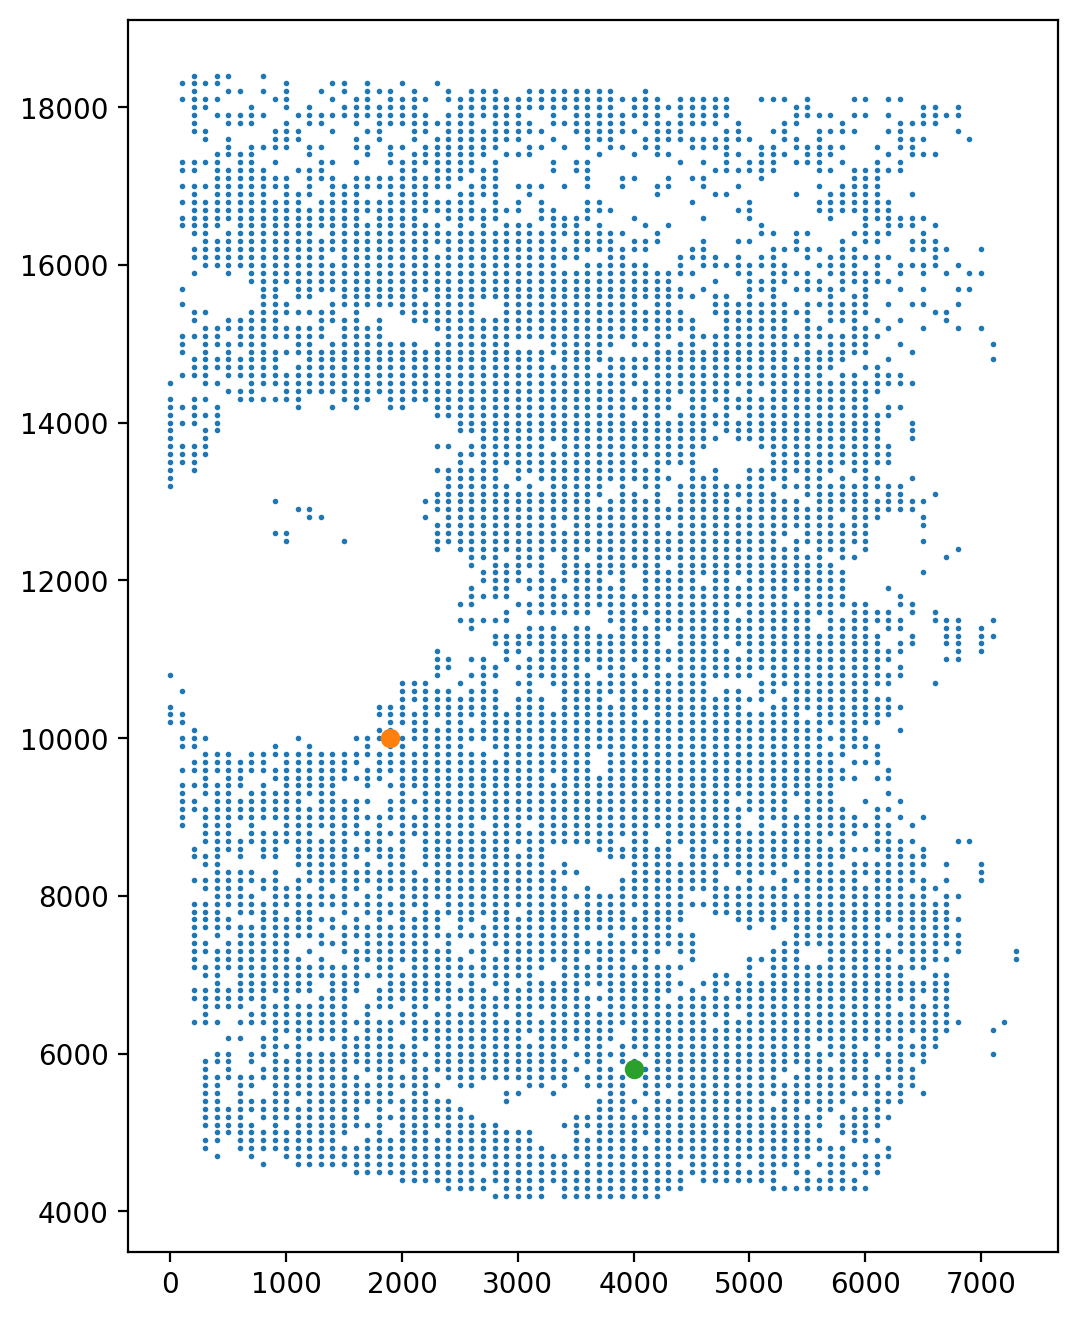

In [15]:

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(6, 8))


LAP_start_point=[1900,10000]
LAP_end_point=[4000,5800]
LAP_start_cell=spt.nearest_neighbors(LAP_start_point,adata.obsm['X_spatial'])[0][0]
LAP_end_cell=spt.nearest_neighbors(LAP_end_point,adata.obsm['X_spatial'])[0][0]

plt.scatter(*adata.obsm["X_spatial"].T,s=1)
plt.scatter(*adata[LAP_start_cell].obsm['X_spatial'].T)
plt.scatter(*adata[LAP_end_cell].obsm['X_spatial'].T)

Get the neighbors according to the spatial location.

In [16]:
sc.pp.neighbors(adata,use_rep='X_spatial',key_added='X_spatial',n_neighbors=100)

Calculate the least action path between given start cell and end cell.

In [17]:
lap=spt.least_action(adata,
    init_cells=adata.obs_names[LAP_start_cell],
    target_cells=adata.obs_names[LAP_end_cell],
    vecfld=VecFld,
    basis='spatial',
    adj_key='X_spatial_distances',
    EM_steps=5,
    n_points=20
)

Visualization of LAP and color bar represents pseudotime.

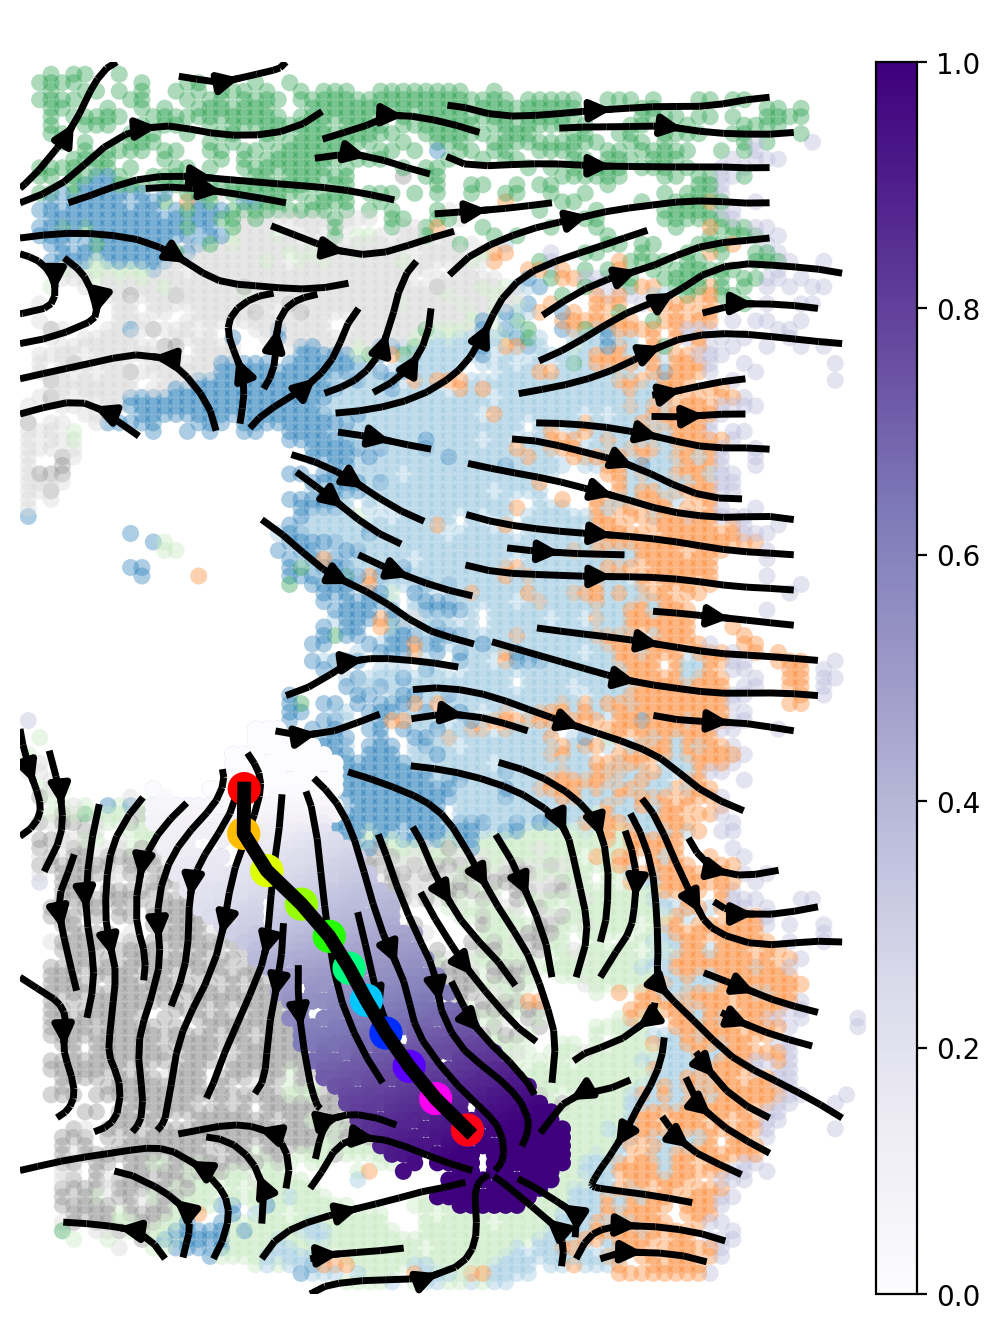

In [18]:
LAP_ptime,LAP_nbrs=spt.lap.map_cell_to_LAP(adata)
sub_adata=adata[LAP_nbrs,:]
sub_adata.obs['ptime']=LAP_ptime
sub_adata=sub_adata[np.argsort(sub_adata.obs["ptime"].values), :].copy()

fig, ax = plt.subplots(figsize=(6,8))
plt.axis('off')
ax = sc.pl.embedding(adata,  basis='X_spatial',color='cluster',show=False,ax=ax,frameon=False,legend_loc=None,alpha=0.4,size=150)
ax.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1],density=1.2,color='black',linewidth=2.5,arrowsize=1.5,minlength=0.1,maxlength=0.8)
ax = spt.plot_least_action_path(adata,basis='spatial',ax=ax,point_size=120,linewidth=5)
sc.pl.embedding(sub_adata, basis='X_spatial',ax=ax, color="ptime", cmap="Purples",frameon=True,size=150,title=' ')

### 7.2 Pseudotime-dependent genes on LAP

Choose cell type of interest on LAP and filter genes with high variability which larger than minimum expression proportion.

In [19]:
sub_adata_path=sub_adata[sub_adata.obs['cluster'].isin(['P0','P3','P4'])]
sub_adata_path=spt.filter_gene(sub_adata_path,min_exp_prop=0.1,hvg_gene=5000)

clusters ordered by ptime:  ['P0', 'P3', 'P4']
Cell number	673
Gene number	1188


To investigate the relationship between gene expression changes and pseudotime values, we applied the generalized additive model (GAM). This allowed us to filter for pseudotime-dependent genes based on their model fit (R2) and false discovery rate (FDR). Only genes that showed significant associations with pseudotime values were selected as pseudotime-dependent genes.

In [20]:
df_res  = spt.ptime_gene_GAM(sub_adata_path,core_number=5)

Genes number fitted by GAM model:   1188


In [21]:
df_sig_res = df_res.loc[(df_res['model_fit']>0.15) & (df_res['fdr']<0.05)]
sort_exp_sig = spt.order_trajectory_genes(sub_adata_path,df_sig_res,cell_number=20)

Finally selected 38 genes.


Use heatmap to display pseudotime-dependent genes.

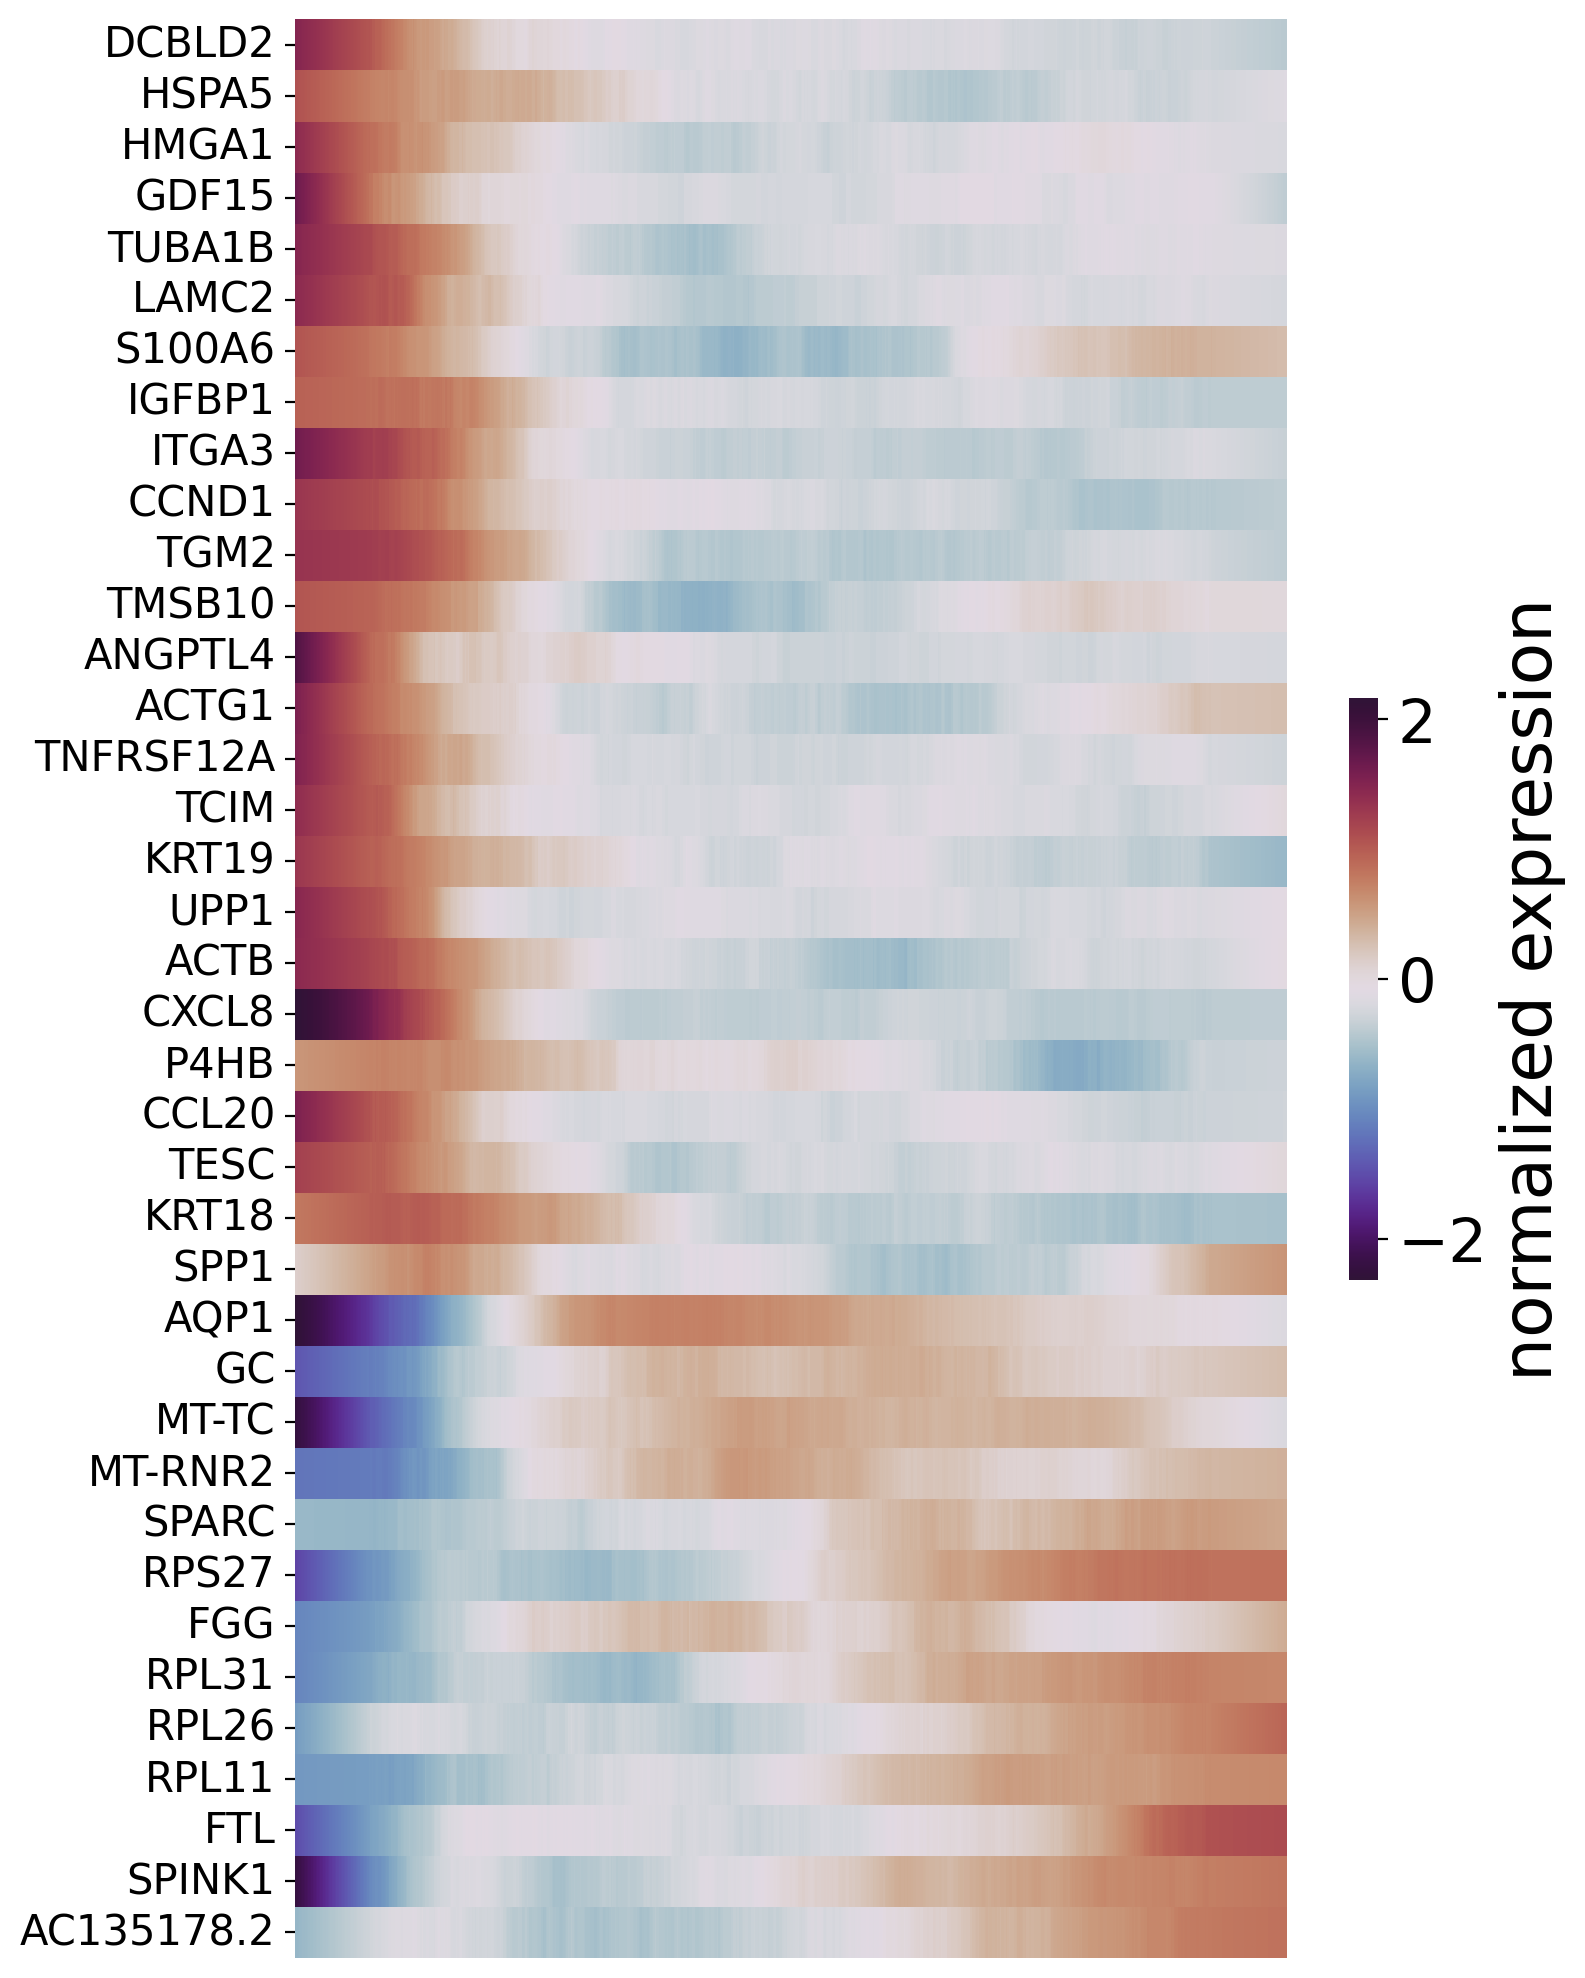

In [22]:
spt.plot_trajectory_gene_heatmap(sort_exp_sig,smooth_length=100,gene_label_size=15,cmap_name='twilight_shifted')

Show example of pseudotime-dependent genes.

<Axes: title={'center': 'AQP1'}, xlabel='ptime', ylabel='expression'>

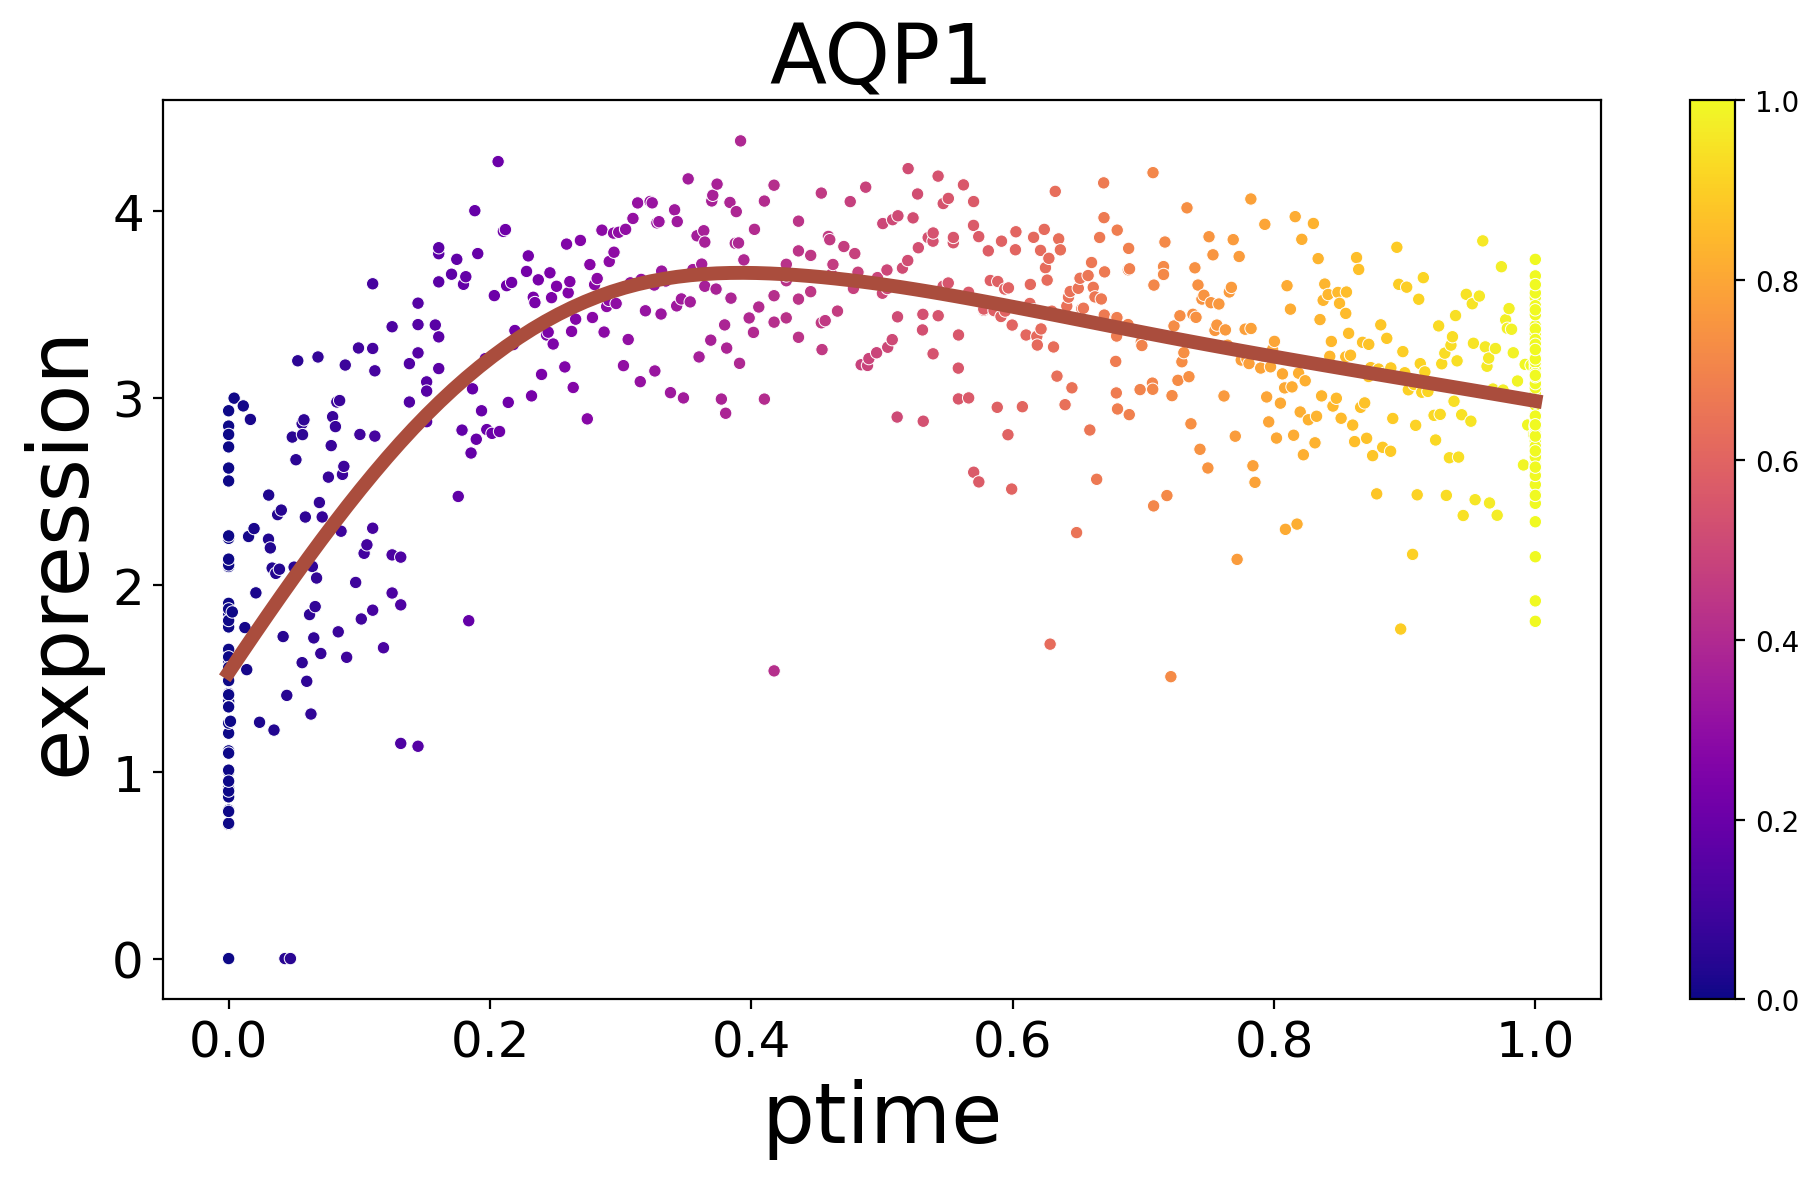

In [23]:
spt.plot_trajectory_gene(sub_adata_path,gene_name='AQP1')

<Axes: title={'center': 'ITGA3'}, xlabel='ptime', ylabel='expression'>

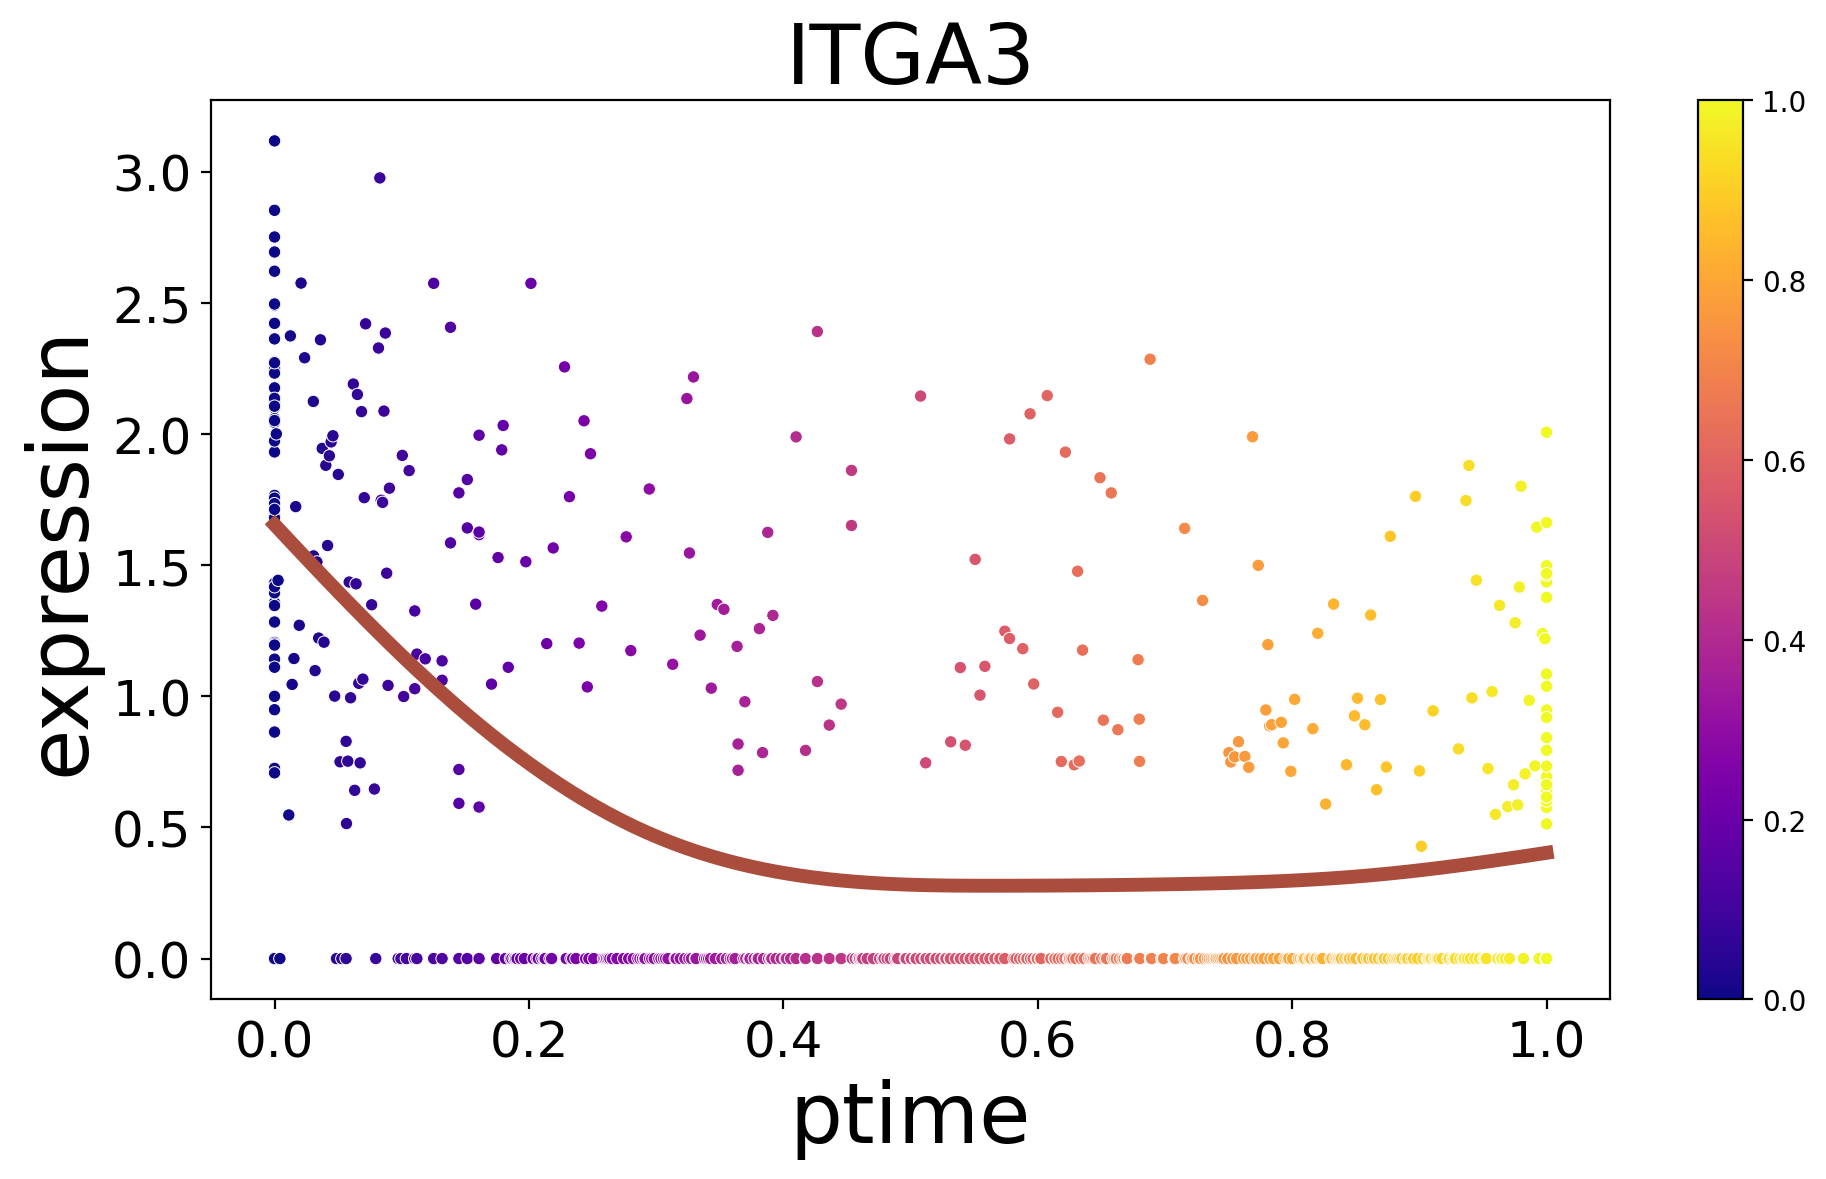

In [24]:
spt.plot_trajectory_gene(sub_adata_path,gene_name='ITGA3')